In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d vijaygiitk/multiclass-weather-dataset

 85% 114M/134M [00:01<00:00, 70.6MB/s]
100% 134M/134M [00:01<00:00, 77.8MB/s]


In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random
import cv2
import tqdm as tqdm
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
#unzipping files
import zipfile
zip_ref = zipfile.ZipFile('/content/multiclass-weather-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [10]:
import os

class_names = ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise', 'alien_test']
image_counts = {}

for name in class_names:
  image_count = len(os.listdir(os.path.join('/content/dataset', folder)))
  image_counts[name] = image_count

print(image_counts)


{'cloudy': 300, 'foggy': 300, 'rainy': 300, 'shine': 250, 'sunrise': 350, 'alien_test': 30}


In [19]:
x = []
y = []
dataset =[]
def create_dataset(directory,dir_name):
    for i in tqdm.tqdm(os.listdir(directory)):
        full_path = os.path.join(directory,i)
        try:
            img = cv2.imread(full_path)
            img = cv2.resize(img,(150,150))
        except:
            continue
        x.append(img)
        y.append(dir_name)
    return x,y

In [20]:
x,y= create_dataset('/content/dataset/foggy',"foggy")
x,y= create_dataset('/content/dataset/sunrise',"sunrise")
x,y= create_dataset('/content/dataset/shine',"shine")
x,y= create_dataset('/content/dataset/rainy',"rainy")
x,y= create_dataset('/content/dataset/cloudy',"cloudy")

100%|██████████| 300/300 [00:00<00:00, 471.68it/s]


In [21]:
x =  np.array(x)
y = np.array(y)
x.shape,y.shape

((1498, 150, 150, 3), (1498,))

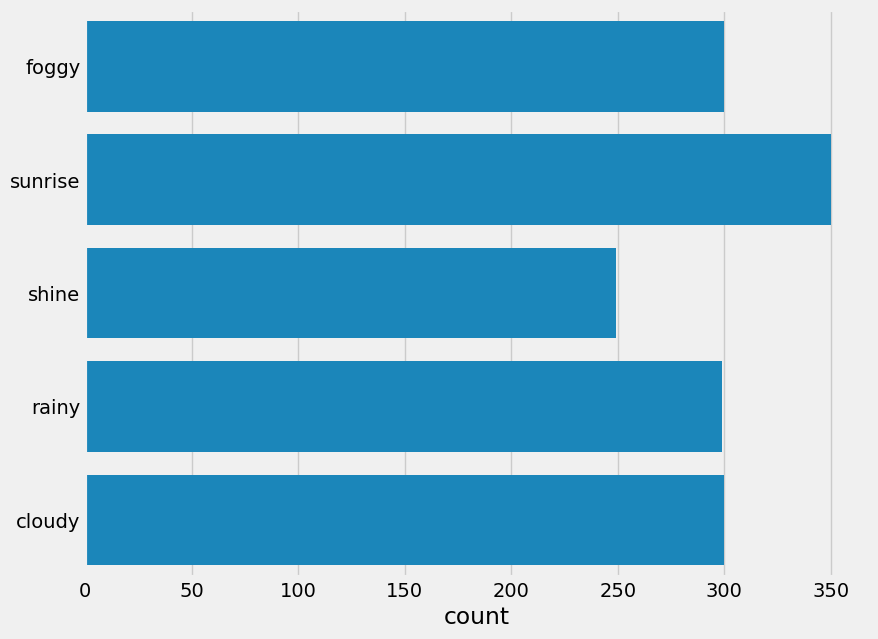

In [23]:
import seaborn as sns
plt.figure(figsize=(9,7))
sns.countplot(y)
plt.show()

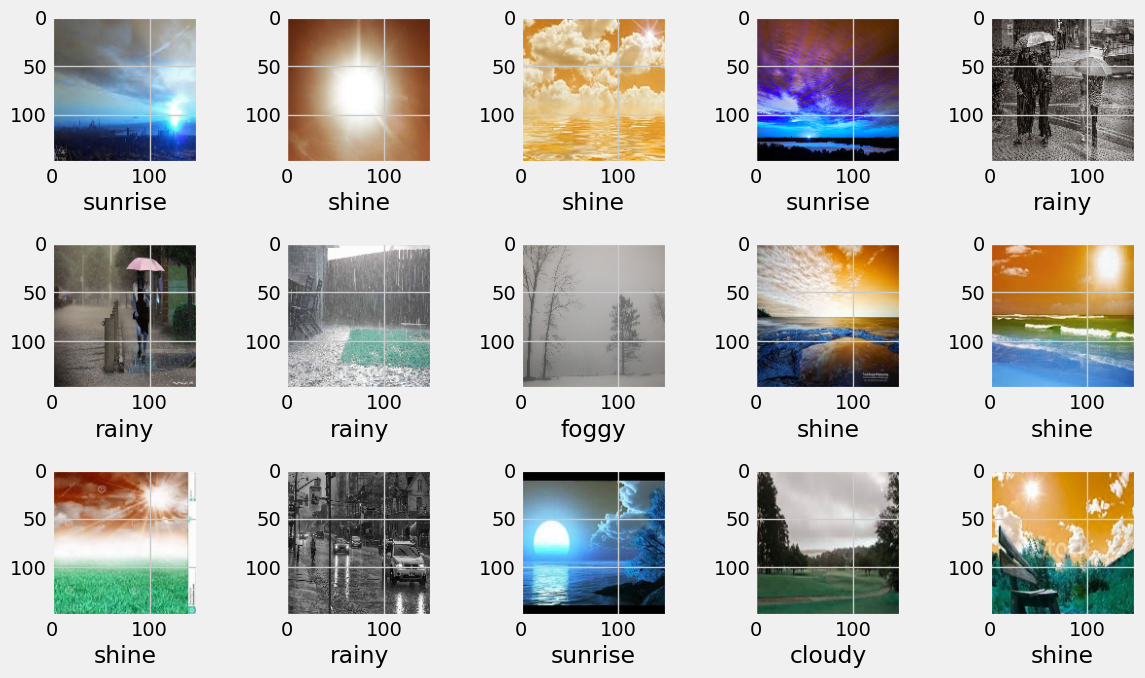

In [25]:
fig = plt.figure(figsize=(12,7))
for i in range(15):
    sample =  random.choice(range(len(x)))
    image = x[sample]
    category = y[sample]
    plt.subplot(3,5,i+1)
    plt.imshow(image)
    plt.xlabel(category)

plt.tight_layout()
plt.show()

In [26]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [32]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)


In [33]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from sklearn.metrics import classification_report

In [38]:
img_size =150

x_train = np.array(x_train)/255.0
x_test = np.array(x_test)/255.0


x_train = x_train.reshape(-1,img_size,img_size,3)
x_test = x_test.reshape(-1,img_size,img_size,3)


In [35]:
y_cat_train = to_categorical(y_train,5)
y_cat_test = to_categorical(y_test,5)

In [37]:
y_cat_train.shape , y_cat_test.shape

((1198, 5), (300, 5))

In [39]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights = "imagenet",include_top=False,input_shape=(img_size,img_size,3))

80134624/80134624 [==============================] - 0s 0us/step


In [40]:
for layer in vgg.layers:
    layer.trainable = False

In [41]:
model =Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(5,activation="softmax"))

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 5)                 40965     
                                                                 
Total params: 20065349 (76.54 MB)
Trainable params: 40965 (160.02 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [43]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics="accuracy")

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [45]:
batch_size=32
history =  model.fit(x_train,y_cat_train,epochs=15,validation_data=(x_test,y_cat_test),
                     batch_size=32 ,verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
38/38 [==============================] - ETA: 0s - loss: 0.9200 - accuracy: 0.6669
Epoch 1: val_accuracy improved from -inf to 0.81333, saving model to vgg19.h5
38/38 [==============================] - 14s 220ms/step - loss: 0.9200 - accuracy: 0.6669 - val_loss: 0.5408 - val_accuracy: 0.8133
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/38 [============================>.] - ETA: 0s - loss: 0.4590 - accuracy: 0.8539
Epoch 2: val_accuracy improved from 0.81333 to 0.82333, saving model to vgg19.h5
38/38 [==============================] - 4s 104ms/step - loss: 0.4574 - accuracy: 0.8548 - val_loss: 0.4986 - val_accuracy: 0.8233
Epoch 3/15
37/38 [============================>.] - ETA: 0s - loss: 0.3138 - accuracy: 0.9046
Epoch 3: val_accuracy improved from 0.82333 to 0.88000, saving model to vgg19.h5
38/38 [==============================] - 4s 103ms/step - loss: 0.3110 - accuracy: 0.9057 - val_loss: 0.3724 - val_accuracy: 0.8800
Epoch 4/15
37/38 [============================>.] - ETA: 0s - loss: 0.2419 - accuracy: 0.9375
Epoch 4: val_accuracy improved from 0.88000 to 0.88667, saving model to vgg19.h5
38/38 [==============================] - 4s 108ms/step - loss: 0.2405 - accuracy: 0.9382 - val_loss: 0.3514 - val_accuracy: 0.8867
Epoch 5/15
37/38 [============================>.] - ETA: 0s - loss: 0.2131 - accuracy: 0.9476

In [46]:
model.metrics_names

['loss', 'accuracy']

In [47]:
model.evaluate(x_test , y_cat_test)

10/10 [==============================] - 1s 82ms/step - loss: 0.3009 - accuracy: 0.9000


[0.30087602138519287, 0.8999999761581421]

In [49]:
predictions = model.predict(x_test)
prediction_classes = np.argmax(predictions , axis=1)

10/10 [==============================] - 1s 87ms/step


In [53]:
report = classification_report(y_test , prediction_classes)

In [51]:
print(report)

              precision    recall  f1-score   support

           0       0.90      0.87      0.88        60
           1       0.77      0.95      0.85        56
           2       0.98      0.87      0.93        71
           3       0.86      0.84      0.85        45
           4       0.98      0.96      0.97        68

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.91      0.90      0.90       300



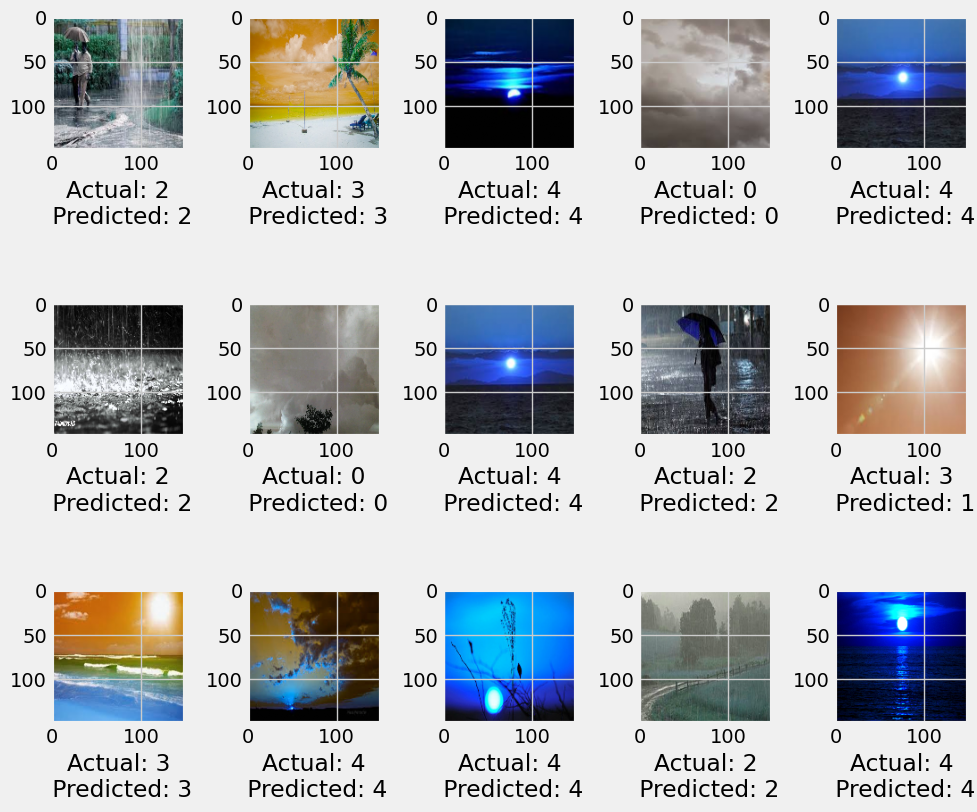

In [56]:
plt.figure(figsize=(10,9))
for i in range(15):
    sample = random.choice(range(len(x_test)))
    plt.subplot(3,5,i+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(x_test[sample])
    plt.xlabel(f"Actual: {y_test[sample]}\n Predicted: {prediction_classes[sample]}")

plt.tight_layout()
plt.show()